In [44]:
import numpy as np
import pandas as pd
import regex as re
import seaborn as sns
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [99]:
%matplotlib inline
sns.set_style("white")

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    'figure.autolayout': False,
    'figure.figsize'   : (15,8),
    'font.size'        : 20,         # default font size (to match the above figsize)
    'ytick.labelsize'  : 'x-small',  # font size relative to the default
    'xtick.labelsize'  : 'x-small',
    'legend.fontsize'  : 'x-small'
})

### Read data

In [51]:
corpora = ['corpus1', 'corpus5']
fig_path = './figures/'
lines = [None]

for corpus in corpora:
    path = './%s.txt' % corpus
    with open(path, 'r') as f:
        lines.append(f.readlines())

Use a tokenizer to parse the header

In [54]:
tokenizer = re.compile(r' *\**\w*_')
useful_range = slice(19, -21)

# tokenize an example of header
tokenizer.split(lines[1][0][useful_range])

['', '26-10-1948', '1948', '10', '26', 'GDL', '1122', '7024']

### Overall stats

In [56]:
yearly_articles = pd.DataFrame(0, index=np.arange(1945, 1996), columns=['GDL1', 'JDG1', 'GDL2', 'JDG2'], dtype=np.uint16)
for corpus in range(1,3):
    for ti in range(len(lines[corpus]) // 3):
        head = lines[corpus][3 * ti + 0]
        text = lines[corpus][3 * ti + 1]
        sep  = lines[corpus][3 * ti + 2]

        fields = tokenizer.split(head[useful_range])
        yearly_articles[fields[5]+str(corpus)][int(fields[2])] += 1
yearly_articles.head()

,GDL1,JDG1,GDL2,JDG2
1945,0,0,0,0
1946,0,0,0,0
1947,0,0,0,0
1948,1,0,0,0
1949,1,0,0,0


### Read countries

In [63]:
countries = pd.read_excel(
    './Liste mots cles.xlsx',
    sheetname='Pays_2',
    index_col='name',
convert_float=True).fillna('')
countries.index.name = 'Pays'

# for now, drop the irrelevant columns
countries = countries[['RegEx', 'ind_year']]
countries.head()

,RegEx,ind_year
Pays,,
Libye,Libye,1951
Soudan,Soudan,1956
Tunisie,Tunisie,1956
Maroc,Maroc,1956
Ghana,Côte-de-l'Or|Ghana,1957


In [64]:
countries.loc['Inde'].RegEx

"Inde[\\s.,;']"

In [65]:
pat = re.compile(countries.RegEx['Inde'], re.IGNORECASE)
for ti in range(len(lines[1]) // 3):
    head = lines[1][3 * ti + 0]
    text = lines[1][3 * ti + 1]
    sep  = lines[1][3 * ti + 2]
    
    matches = pat.findall(text)
    if matches:
        print(matches)
    

['Inde,', 'Inde ']
['Inde,']
['Inde ']
['Inde ', 'Inde ']
['Inde,']
['Inde ', 'Inde,', 'Inde ']
['Inde ']
['Inde ']
['Inde,']
['Inde ', 'Inde ']
['Inde ']
['Inde,']
['Inde ']
['Inde ', 'Inde ', 'Inde ', 'Inde ']
['Inde ', 'Inde ']
['Inde ']
['Inde.', 'Inde ', 'Inde,', 'Inde ', 'Inde ']
['Inde ']
['Inde ']
['Inde ', 'Inde ', 'Inde,', 'Inde ', 'Inde ']
['Inde,']
['Inde,', 'Inde,', 'Inde ', 'Inde.', 'Inde ']
['Inde,']
['Inde ', 'Inde ', 'Inde.', 'Inde ', 'Inde,']
['Inde ']
['Inde ']
['Inde ', 'Inde,']
['Inde ']
['Inde ', 'Inde,', 'Inde,']
['Inde ']
['Inde ', 'Inde,', 'Inde ']
['Inde,']
['Inde,']
['Inde,', 'Inde ']
['Inde,']
['Inde ']
['Inde ', 'Inde.']
['Inde,', 'Inde ']
['Inde.']
['Inde ']
['Inde ']
['Inde ', 'Inde,']
['Inde ', 'Inde,']
['Inde ', 'Inde,', 'Inde ', 'Inde ', 'Inde ']
['INDE ', 'Inde ', 'Inde.', 'Inde ']
['Inde ', 'Inde ']
['Inde,']
['Inde,']
['Inde,']
['Inde,', 'Inde,', 'Inde,', 'Inde,']
['Inde ', 'Inde ']
['Inde ']
['Inde ']
['Inde ']
['Inde,']
['Inde ']
['Inde,']
['Inde.

### Stats per country

In [66]:
def process_country(country_entry, lines):
    country = re.compile(country_entry.RegEx, flags=re.IGNORECASE)
    global tokenizer, useful_range

    for corpus in range(1,3):
        words_jdg, words_gdl = 0, 0
        num_articles = 0
        for ti in range(len(lines[corpus]) // 3):
            head = lines[corpus][3 * ti + 0]
            text = lines[corpus][3 * ti + 1]
            sep  = lines[corpus][3 * ti + 2]

            # check we don't skip stuff
            # assert (head.count('*') == 13)  # **** + 10 variables - 1 wrong variable
            # assert (sep.strip() == '')

            if country.search(text):
                fields = tokenizer.split(head[useful_range])
                if fields[5] == 'GDL':
                    words_gdl += int(fields[6])
                else:
                    words_jdg += int(fields[6])
                num_articles += 1
        country_entry['wGDL' + str(corpus)]     = words_gdl
        country_entry['wJDG' + str(corpus)]     = words_jdg
        country_entry['wTOT' + str(corpus)]     = words_jdg + words_gdl
        country_entry['articles' + str(corpus)] = num_articles
    return country_entry

In [67]:
countries = countries.apply(process_country, axis='columns', args=(lines,))
countries.head()

,RegEx,ind_year,wGDL1,wJDG1,wTOT1,articles1,wGDL2,wJDG2,wTOT2,articles2
Pays,,,,,,,,,,
Libye,Libye,1951,21178,28270,49448,85,2156,4224,6380,7
Soudan,Soudan,1956,24924,28739,53663,65,10949,13294,24243,20
Tunisie,Tunisie,1956,40436,54432,94868,152,15402,14476,29878,39
Maroc,Maroc,1956,77460,93867,171327,286,14528,6933,21461,27
Ghana,Côte-de-l'Or|Ghana,1957,33350,26486,59836,78,10540,3925,14465,13


In [68]:
countries['wAVG1'] = countries.wTOT1 / countries.articles1
countries['wAVG2'] = countries.wTOT2 / countries.articles2

In [70]:
print(countries.articles1['Algérie'])
print(countries.articles2['Algérie'])

599
83


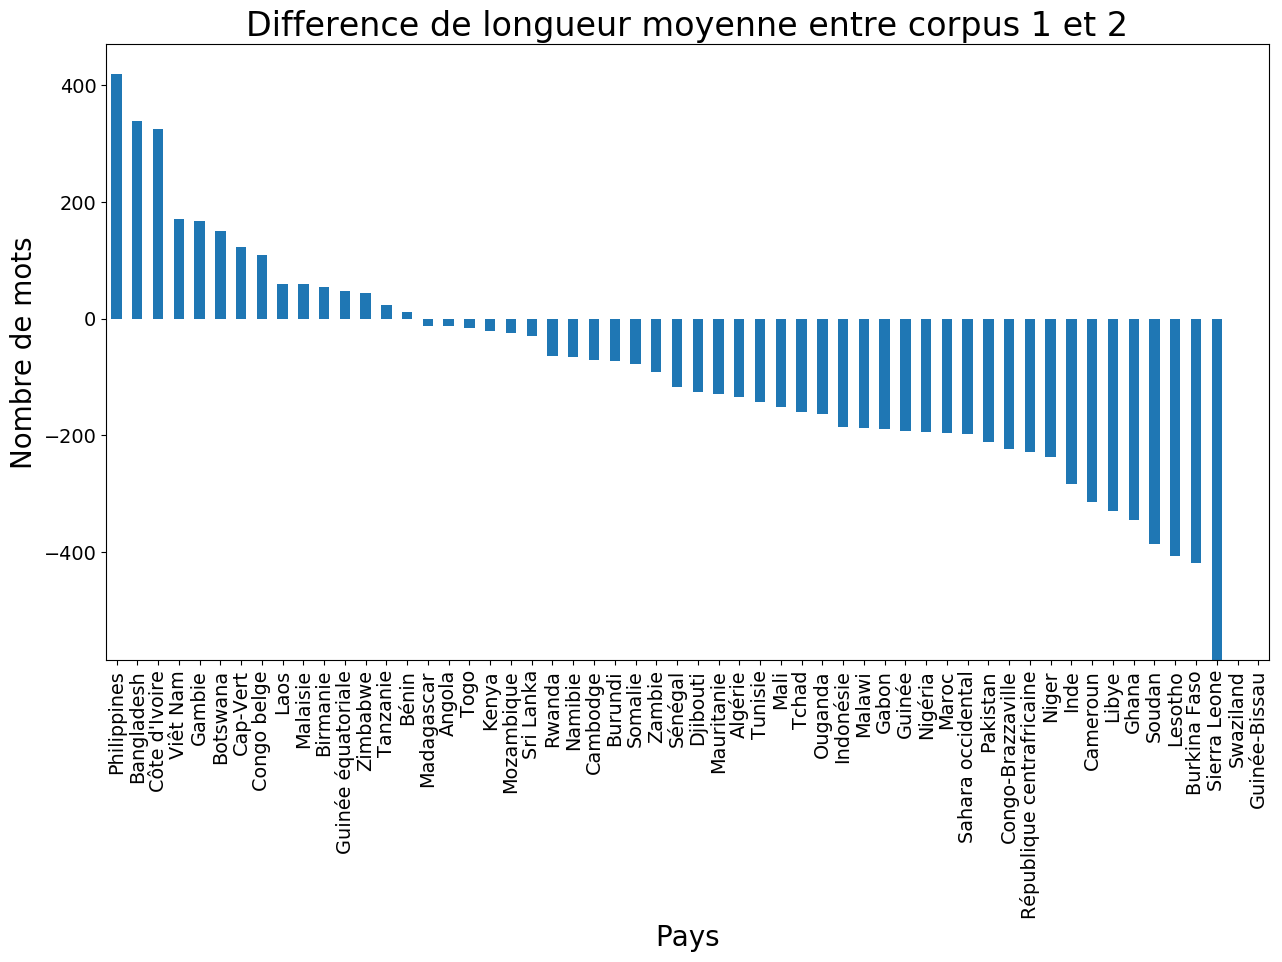

In [92]:
ax = (countries.wAVG1 - countries.wAVG2).sort_values(ascending=False).plot.bar()
ax.set_ylabel('Nombre de mots')
ax.set_title('Difference de longueur moyenne entre corpus 1 et 2')

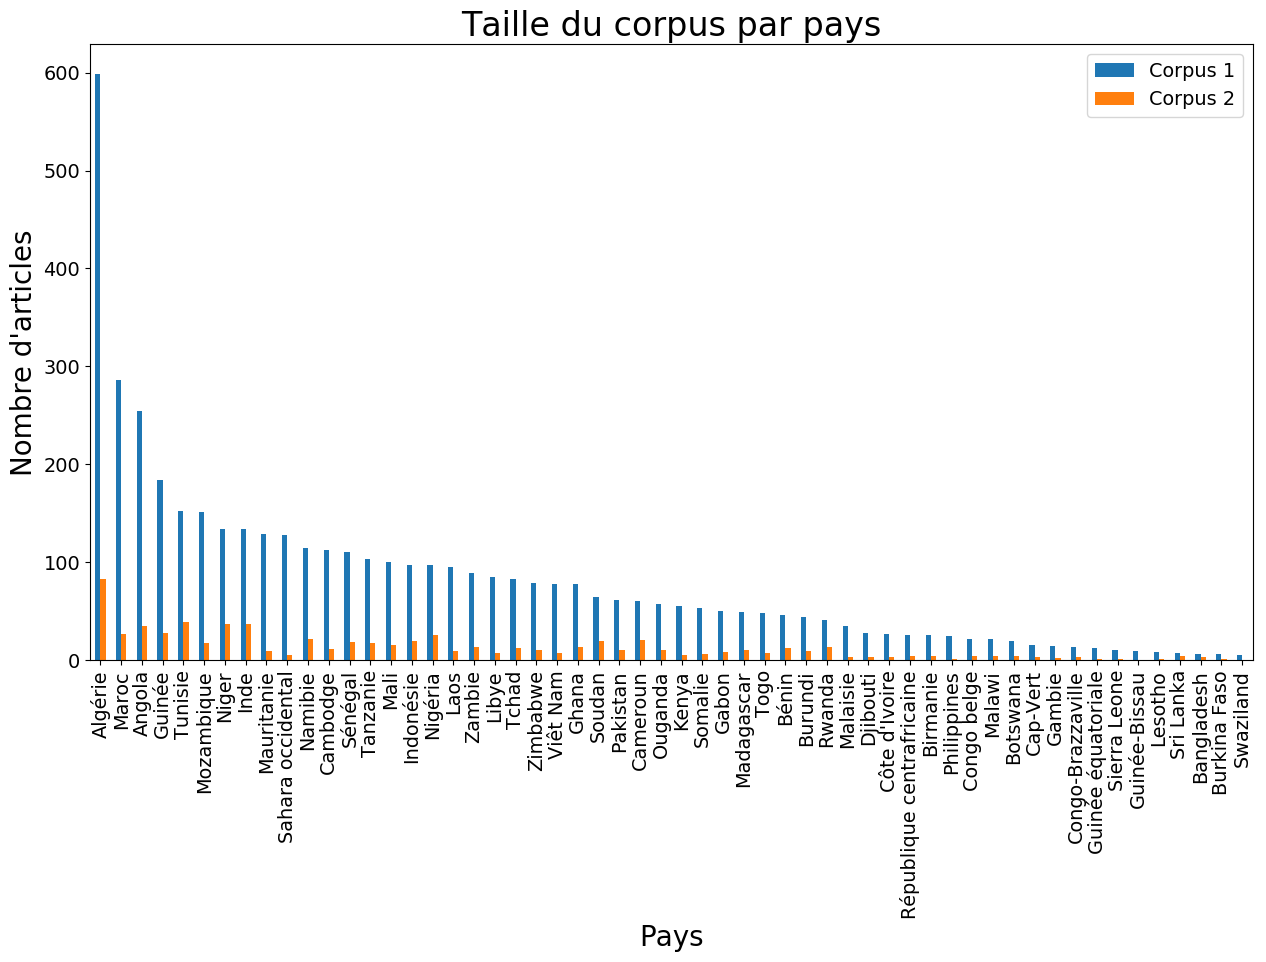

In [102]:
ax = countries[['articles1', 'articles2']].sort_values('articles1', ascending=False).plot.bar()
ax.set_ylabel("Nombre d'articles")
ax.set_title('Taille du corpus par pays')
ax.legend(['Corpus 1', 'Corpus 2'])

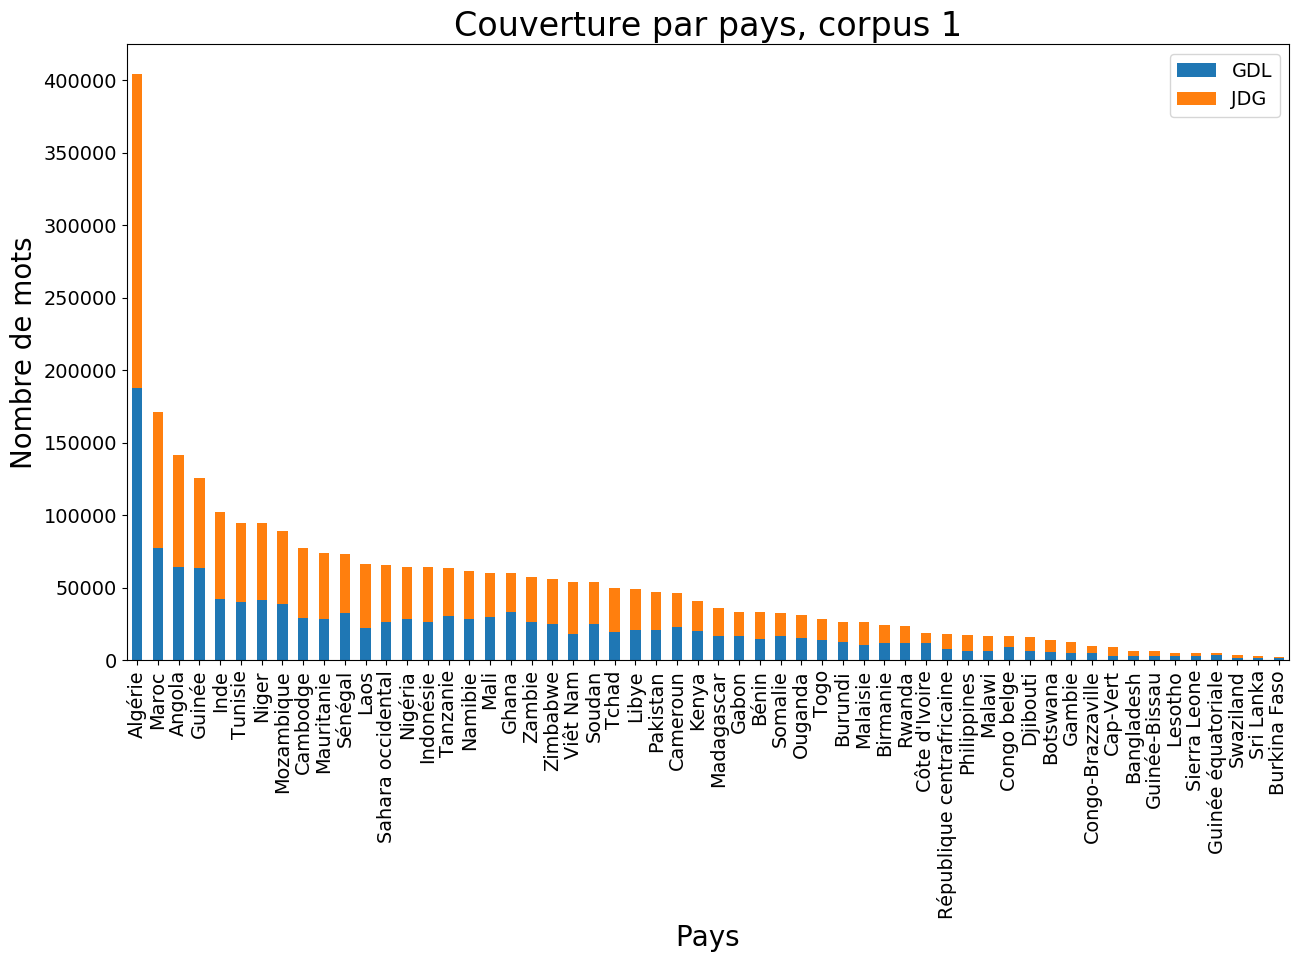

In [112]:
ax = countries[['wGDL1', 'wJDG1', 'wTOT1']].sort_values('wTOT1', ascending=False)\
        .drop('wTOT1', axis='columns')\
        .plot.bar(stacked=True)
ax.set_ylabel('Nombre de mots')
# ax.set_ylim(top=250000)  # to make cut axes
ax.legend(['GDL', 'JDG'])
ax.set_title('Couverture par pays, corpus 1')
# plt.savefig(fig_path + 'mots_total.png', bbox_inches='tight')

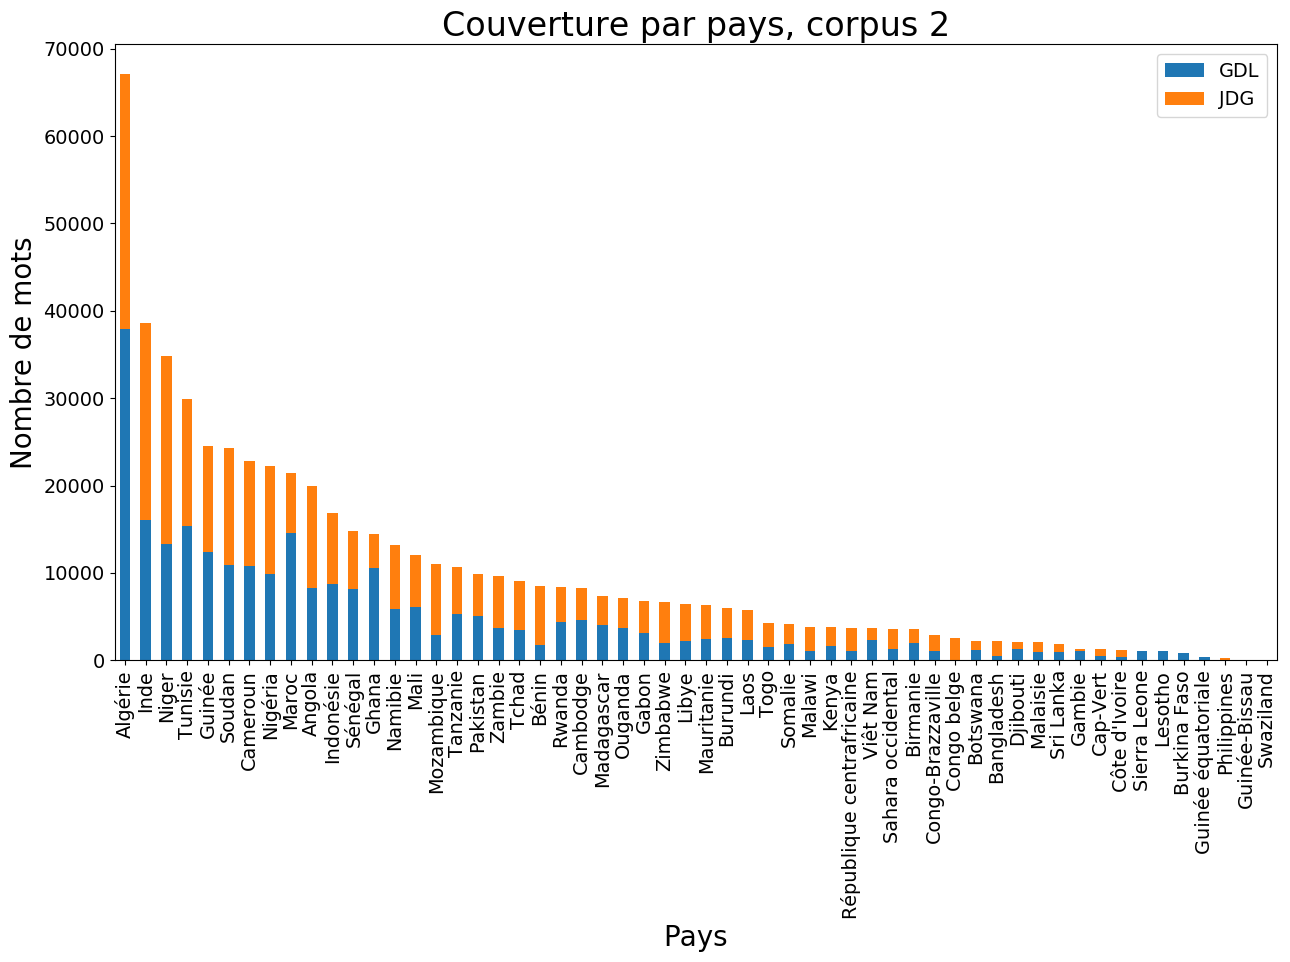

In [116]:
ax = countries[['wGDL2', 'wJDG2', 'wTOT2']].sort_values('wTOT2', ascending=False)\
        .drop('wTOT2', axis='columns')\
        .plot.bar(stacked=True)
ax.set_ylabel('Nombre de mots')
# ax.set_ylim(top=250000)  # to make cut axes
ax.legend(['GDL', 'JDG'])
ax.set_title('Couverture par pays, corpus 2')
# plt.savefig(fig_path + 'mots_total.png', bbox_inches='tight')

In [96]:
ind_by_year = countries_md.groupby(['ind_year']).count().RegEx

In [97]:
# some years are missing, so add the zeros in between
ind_by_year_aligned = pd.Series(0, index=np.arange(1945, 1996))
ind_by_year_aligned[ind_by_year.index] = ind_by_year

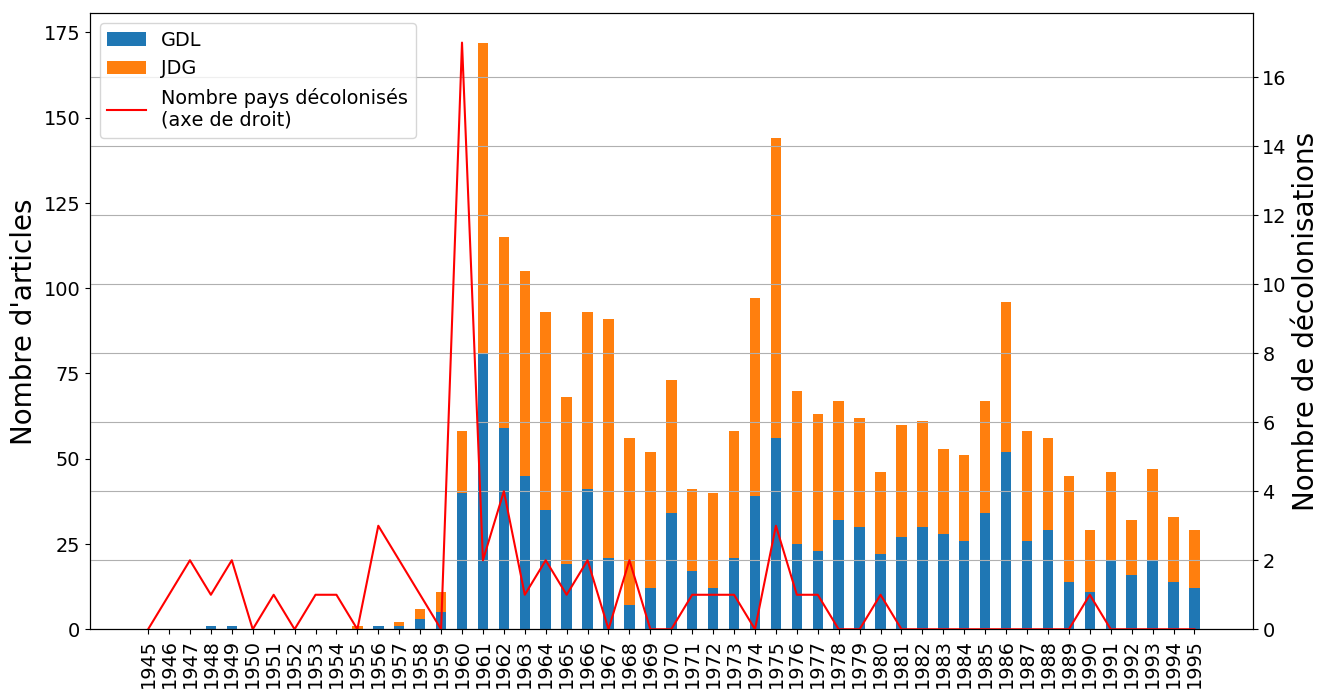

In [115]:
ax_bar = yearly_articles[['GDL1', 'JDG1']].rename(columns={'GDL1':'GDL', 'JDG1':'JDG'}).plot.bar(stacked=True)
ax_bar.set_ylabel("Nombre d'articles")

ax_line = ax_bar.twinx()
ax_line.plot(ax_bar.get_xticks(), ind_by_year_aligned, 'r', label='Nombre pays décolonisés\n(axe de droit)')
ax_line.yaxis.grid(True)
ax_line.set_ylabel("Nombre de décolonisations")
ax_line.set_ylim(0)

# setup legend
bars, bar_labels  = ax_bar.get_legend_handles_labels()
line, line_labels = ax_line.get_legend_handles_labels()
ax_bar.legend_.remove()
ax_line.legend(bars + line, bar_labels + line_labels, loc='upper left')

# plt.savefig(fig_path + 'num_decolonis.png', bbox_inches='tight')

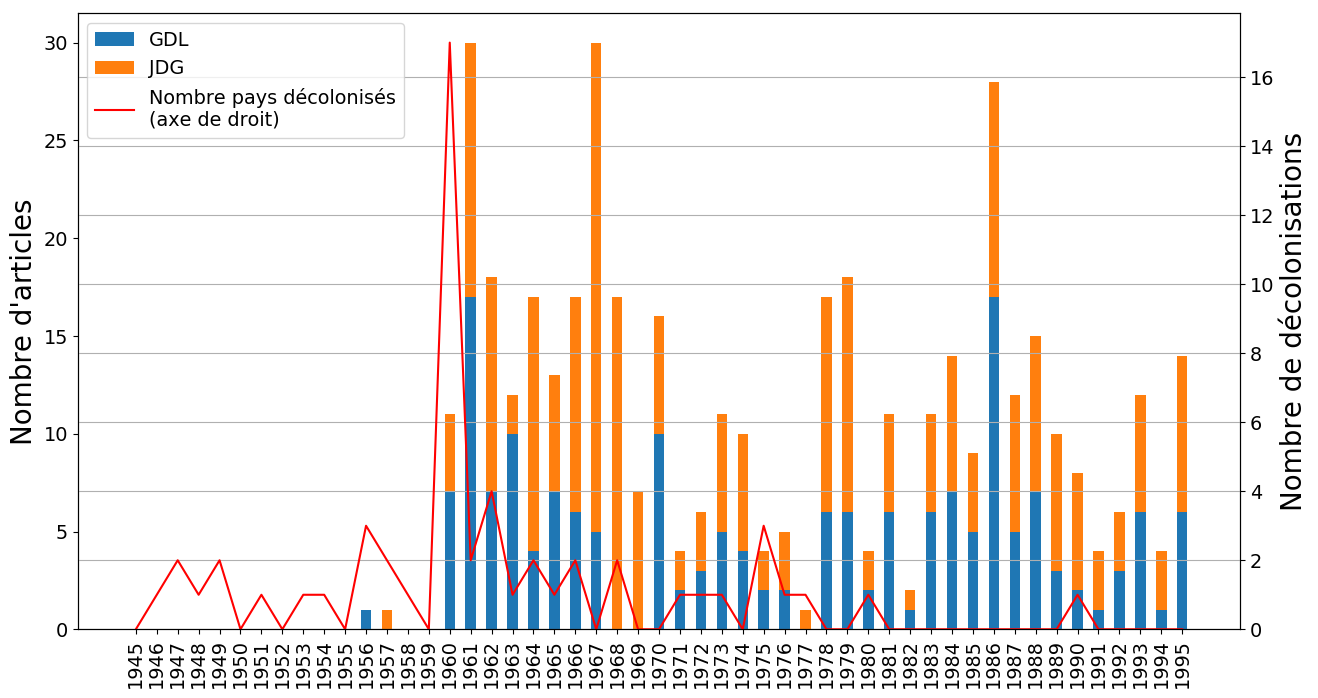

In [117]:
ax_bar = yearly_articles[['GDL2', 'JDG2']].rename(columns={'GDL2':'GDL', 'JDG2':'JDG'}).plot.bar(stacked=True)
ax_bar.set_ylabel("Nombre d'articles")

ax_line = ax_bar.twinx()
ax_line.plot(ax_bar.get_xticks(), ind_by_year_aligned, 'r', label='Nombre pays décolonisés\n(axe de droit)')
ax_line.yaxis.grid(True)
ax_line.set_ylabel("Nombre de décolonisations")
ax_line.set_ylim(0)

# setup legend
bars, bar_labels  = ax_bar.get_legend_handles_labels()
line, line_labels = ax_line.get_legend_handles_labels()
ax_bar.legend_.remove()
ax_line.legend(bars + line, bar_labels + line_labels, loc='upper left')

# plt.savefig(fig_path + 'num_decolonis.png', bbox_inches='tight')

Old cell showing interest as avg article length and number of articles (both per country), but only for 1 corpus

/home/tomoiaga/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


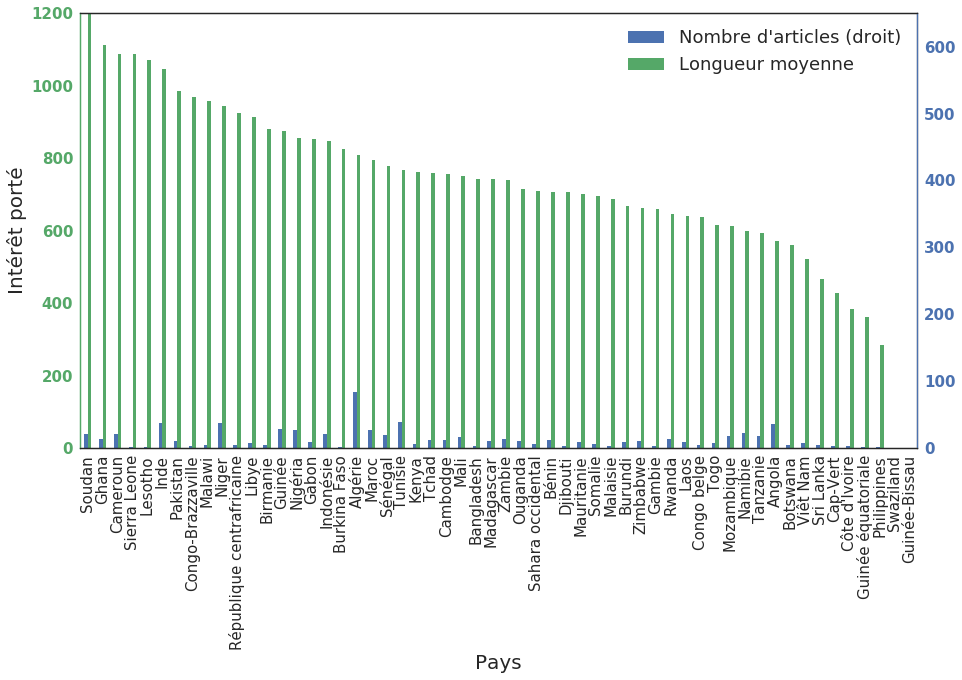

In [31]:
ax = countries_md[['articles', 'wAVG']].sort_values('wAVG', ascending=False).plot.bar()
ax.set_ylabel('Intérêt porté')
ax.set_ylim(top=1200)

ax_articles = ax.twinx()
for r in ax.patches[:len(countries_md)]:
    r.set_transform(ax_articles.transData)

ax_articles.set_ylim(top=650)
ax.legend(["Nombre d'articles (droit)",'Longueur moyenne'])

# color their axes
c = sns.color_palette()[0]
ax_articles.spines['right'].set_color(c)
ax_articles.tick_params(axis='y', colors=c)
ax_articles.set_yticklabels(ax_articles.get_yticklabels(), weight='bold')
ax_articles.yaxis.set_major_formatter(FormatStrFormatter("%d"))

c = sns.color_palette()[1]
ax.spines['left'].set_color(c)
ax_articles.spines['left'].set_color(c)  # because it overlaps the previous one
ax.tick_params(axis='y', colors=c)
ax.set_yticklabels(ax_articles.get_yticklabels(), weight='bold')
ax.yaxis.set_major_formatter(FormatStrFormatter("%d"))

plt.savefig(fig_path + 'interest.png', bbox_inches='tight')